### 首先引入需要的库
+ numpy
+ h5py:用于读取h5格式的数据文件
+ matplotlib: 用于绘制图表
+ lr_utils: 文件已给出，用于加载h5中的数据

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from lr_utils import load_dataset
train_set_x_orig, train_set_y_orig,test_set_x_orig,test_set_y_orig,classes=load_dataset()
print("size of the training set data:"+str(train_set_x_orig.shape))
print("size of the training set label:"+str(train_set_y_orig.shape))
print("type of classes:"+str(type(classes)))
print("content of classes:"+str(classes))

size of the training set data:(209, 64, 64, 3)
size of the training set label:(1, 209)
type of classes:<class 'numpy.ndarray'>
content of classes:[b'non-cat' b'cat']


读取h5数据文件后：
+ train_set_x_orig: 表示原始训练数据，储存了209幅64*64的RGB图像
+ train_set_y_orig：每张图片的类型，0表示不是猫，1表示是猫
+ test_set_x_orig, test_set_y_orig的意义与训练集相同
+ classes:储存图片类型的列表，在这一project中由于是二分类问题，只有两种类型：cat和non-cat

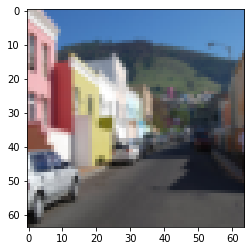

In [12]:
index=1
plt.imshow(train_set_x_orig[index])

In [14]:
m_train = train_set_y_orig.shape[1] #训练数据个数
m_test = test_set_y_orig.shape[1] #测试数据个数
num_px = train_set_x_orig.shape[1] #训练数据（图片）的边长像素数

### 图片是一个64x64x3的三维矩阵，将其unroll为向量便于训练
reshape函数中的-1参数表示由系统计算列数
同时为了训练数据矩阵X满足Ng课上的形式，将unroll后的矩阵进行转置，使其每列都是一个图片像素数据。

In [15]:
train_set_x_unroll = train_set_x_orig.reshape(train_set_y_orig.shape[1],-1).T
test_set_x_unroll = test_set_x_orig.reshape(test_set_y_orig.shape[-1],-1).T
print("train data size after unrolling:"+str(train_set_x_unroll.shape))
print("test data size after unrolling:"+str(test_set_x_unroll.shape))

train data size after unrolling:(12288, 209)
test data size after unrolling:(12288, 50)


### 数据的normalization工作
normalization的目的在于将数据值投影到一个范围，比如[0,1]范围。
由于RGB的像素最大值为255，所以将像素值除以255即可完成。

In [16]:
train_set_x = train_set_x_unroll/255; # broadcasting
test_set_x = test_set_x_unroll/255;

### 至此数据的载入（load）和预处理工作完成，接下来就是模型构建。
### Logistic Regression的大致步骤为
1. 初始化w,b参数
2. 循环：
    1. 前向传播 计算中间参数值
    2. 后向传播 计算梯度
    3. Gradient Descent梯度下降更新参数值
    
首先完成sigmoid函数功能。

In [22]:
def sigmoid(z):
    """
    z:矩阵或标量
    
    """
    return 1/(1+np.exp(-z))

In [23]:
# sigmoid测试
print("==========================Sigmoid Test==========================")
print("sigmoid(0):"+str(sigmoid(0)))
print("sigmoid(-1):"+str(sigmoid(-1)))

==========================Sigmoid Test==========================
sigmoid(0):0.5
sigmoid(-1):0.2689414213699951


### 参数初始化

In [36]:
def init(dim):
    """
    参数：dim - 返回w向量的行数
    返回：
        w - (dim,1)的零向量
        b - 初始化值为0
    """
    w = np.zeros((dim,1))
    b = 0
    
    # Use assert to judge if shape is correct
    assert(w.shape == (dim,1))
    assert(isinstance(b,int) or isinstance(b,float))
    
    return w,b

### 前向传播和后向传播计算梯度

In [25]:
def propagate(w,b,X,Y):
    """
    实现前向传播和后向传播
    
    参数：
        w:(64x64x3,1)
        b:bias
        X:训练数据 size为(64x64x3,229)
        Y:标签，size为（1，229）
    返回：
        cost:当前损失函数的值
        dw: w梯度
        db：b梯度
    """
    m = X.shape[1]
    ### forward prop
    Z = np.dot(w.T,X)+b
    A = sigmoid(Z)
    dz = A - Y
    cost = -(1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
    dw = (1/m)*np.dot(X,dz.T)
    db = (1/m)*np.sum(dz)
    
    assert(dw.shape==w.shape)
    cost = np.squeeze(cost)
    assert(cost.shape==())
    
    grads={
        "dw":dw,
        "db":db
    }
    
    return grads,cost

In [26]:
#测试一下propagate
print("====================测试propagate====================")
#初始化一些参数
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))


====================测试propagate====================
dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


### 梯度下降

In [38]:
def optimize(w,b,X,Y,num_iterations,learning_rate,print_cost=False):
    """
    参数：
        w,b,X,Y略
        num_iterations: 迭代次数
        learning_rate:学习率
        print_cost：每迭代100次打印一次损失函数
    返回：
        params - w和b的字典
        grads - dw 和 db的字典
        costs - 记录每次迭代成本函数的值的列表
    """
    costs = []
    for i in range(num_iterations):
        grads,cost = propagate(w,b,X,Y)
        costs.append(cost)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b- learning_rate * db
        
        if(i%100==0) and (print_cost==True):
            print("Cost at iteration %d : %f"%(i,cost))
    params = {
        "w":w,
        "b":b
    }
    return params,grads,costs

In [30]:
#测试optimize
print("====================测试optimize====================")
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
params , grads , costs = optimize(w , b , X , Y , num_iterations=100 , learning_rate = 0.009 , print_cost = False)
print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))


====================测试optimize====================
w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


### 根据参数进行预测

In [48]:
def predict(w,b,X):
    """
    预测图片是否是猫，函数输出值大于0.5则是，否则不是
    
    输出：
        Y-prediction:预测标签
    """
    m = X.shape[1]
    Z = np.dot(w.T,X)+b
    A = sigmoid(Z)
   # print(A.shape)
    
    Y_prediction = np.zeros((1,m))
    for i in range(m):
        if(A[:,i]>0.5):
            Y_prediction[:,i] = 1
        else:
            Y_prediction[:,i] = 0
    return Y_prediction

### 整合
将参数初始化、前向传播、后向传播、梯度下降、预测整合到一个函数中

In [64]:
def model(X_train,Y_train,X_test,Y_test,num_iterations=2000,learning_rate=0.5,print_cost=False):
    # 参数初始化
    dim = X_train.shape[0]
    w,b=init(dim)
    # 梯度下降
    params,grads,costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    w = params["w"]
    b = params["b"]
    Y_train_prediction = predict(w,b,X_train)
    Y_test_prediction = predict(w,b,X_test)
    
    m_train = X_train.shape[1]
    m_test = X_test.shape[1]
    count_train = 0
    count_test = 0
    
    for i in range(m_train):
        if(Y_train_prediction[:,i]==Y_train[:,i]):
            count_train+=1
    for j in range(m_test):
        if(Y_test_prediction[:,j]==Y_test[:,j]):
            count_test+=1
    print("Training set accuracy:"+str(float(count_train/m_train)))
    print("Test set accuracy:"+str(float(count_test/m_test)))
    d = {
        "costs":costs,
        "Y_train_prediction":Y_train_prediction,
        "Y_test_prediction":Y_test_prediction,
        "w":w,
        "b":b,
        "learning_rate":learning_rate,
        "num_iterations":num_iterations
    }
    return d

### 测试
至此模型的关键部分已经训练完成，我们调用model函数对模型进行测试，观察随着迭代次数的增加，代价函数是否递减，以及最后测试集和训练集的准确率。

In [54]:
d = model(train_set_x,train_set_y_orig,test_set_x,test_set_y_orig,2000,0.005,True)

Cost at iteration 0 : 0.693147
Cost at iteration 100 : 0.584508
Cost at iteration 200 : 0.466949
Cost at iteration 300 : 0.376007
Cost at iteration 400 : 0.331463
Cost at iteration 500 : 0.303273
Cost at iteration 600 : 0.279880
Cost at iteration 700 : 0.260042
Cost at iteration 800 : 0.242941
Cost at iteration 900 : 0.228004
Cost at iteration 1000 : 0.214820
Cost at iteration 1100 : 0.203078
Cost at iteration 1200 : 0.192544
Cost at iteration 1300 : 0.183033
Cost at iteration 1400 : 0.174399
Cost at iteration 1500 : 0.166521
Cost at iteration 1600 : 0.159305
Cost at iteration 1700 : 0.152667
Cost at iteration 1800 : 0.146542
Cost at iteration 1900 : 0.140872
Training set accuracy:0.9904306220095693
Test set accuracy:0.7


### 绘制Cost Function图像

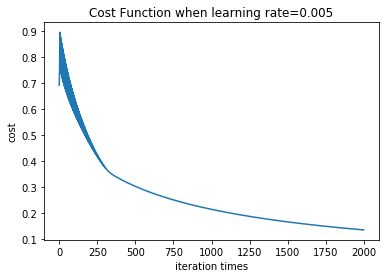

In [56]:
costs = d["costs"]
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iteration times')
plt.title('Cost Function when learning rate=0.005')
plt.show()

Cost at iteration 0 : 0.693147
Cost at iteration 100 : 0.823921
Cost at iteration 200 : 0.418944
Cost at iteration 300 : 0.617350
Cost at iteration 400 : 0.522116
Cost at iteration 500 : 0.387709
Cost at iteration 600 : 0.236254
Cost at iteration 700 : 0.154222
Cost at iteration 800 : 0.135328
Cost at iteration 900 : 0.124971
Cost at iteration 1000 : 0.116478
Cost at iteration 1100 : 0.109193
Cost at iteration 1200 : 0.102804
Cost at iteration 1300 : 0.097130
Cost at iteration 1400 : 0.092043
Cost at iteration 1500 : 0.087453
Cost at iteration 1600 : 0.083286
Cost at iteration 1700 : 0.079487
Cost at iteration 1800 : 0.076007
Cost at iteration 1900 : 0.072809
Training set accuracy:0.9952153110047847
Test set accuracy:0.7
Cost at iteration 0 : 0.693147
Cost at iteration 100 : 0.643677
Cost at iteration 200 : 0.635737
Cost at iteration 300 : 0.628572
Cost at iteration 400 : 0.622040
Cost at iteration 500 : 0.616029
Cost at iteration 600 : 0.610455
Cost at iteration 700 : 0.605248
Cost at

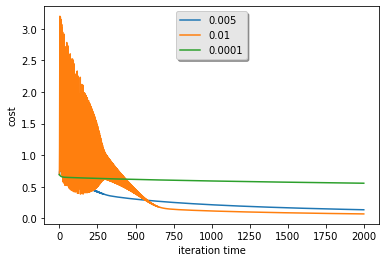

In [66]:
d2 = model(train_set_x,train_set_y_orig,test_set_x,test_set_y_orig,2000,0.01,True)
d3 = model(train_set_x,train_set_y_orig,test_set_x,test_set_y_orig,2000,0.0001,True)
models=[]
models.append(d)
models.append(d2)
models.append(d3)
for m in models:
    plt.plot(m["costs"],label=str(m["learning_rate"]))
plt.ylabel("cost")
plt.xlabel("iteration time")
legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()